# 导入第三方库

In [2]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from random import *
from math import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from collections import Counter
from itertools import cycle
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import tensorflow as tf
import matplotlib as mpl
import seaborn as sns

# 数据输入和准备

In [3]:
df=pd.read_csv("otu-0422.tsv",sep="\t")
sample_list=list(df.groupby(df["sample"]))

# 读取文件
def df_trans(my_tumple):
    return pd.DataFrame(my_tumple[1][['reads']].values.T,index=[my_tumple[0]],columns=my_tumple[1]['otu'].tolist())

In [4]:
otu

NameError: name 'otu' is not defined

In [14]:
# otu=pd.concat(map(df_trans,sample_list))
# otu.fillna(0, inplace=True)
# otu=otu.astype(int)
label=pd.read_csv("otu-0422type.txt",sep="\t",index_col=0)
otu_label=pd.concat([otu,label], axis=1,join='inner')
otu_label

,Otu2,Otu114,Otu39,Otu4,Otu19,Otu26,Otu80,Otu15,Otu125,Otu17,...,Otu4328,Otu3846,Otu2194,Otu4483,Otu5388,Otu5569,Otu3074,Otu3845,Otu2754,type
NH10,8385,2514,2591,2681,594,1348,848,2674,11,5378,...,0,0,0,0,0,0,0,0,0,fjz
NH100,531,1,1,23,0,1768,0,173,0,597,...,0,0,0,0,0,0,0,0,0,cr
NH107,5287,5,0,12,0,1003,0,15,0,1020,...,0,0,0,0,0,0,0,0,0,jk
NH11,10207,0,0,9,7,0,1,832,25,19,...,0,0,0,0,0,0,0,0,0,jk
NH110,968,1,0,551,30,9,0,9,0,6,...,0,0,0,0,0,0,0,0,0,jz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NH93,7,0,0,1613,52,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,cr
NH94,3269,0,0,1495,109,1339,0,666,999,2275,...,0,0,0,0,0,0,0,0,0,fjz
NH95,14754,0,0,779,251,2323,0,65,0,2421,...,0,0,0,0,0,0,0,0,0,cr
NH98,3106,778,3,2588,3167,272,7,14,16,713,...,1,3,4,6,1,1,1,0,0,jz


In [18]:
otu_label.to_csv("otu_108.csv",index=1)

In [4]:
##-------------------定义特征筛选函数1-----------------
def filter(otu,thread):
    n = len(otu)
    columns = otu.columns
    for col in columns:
        more_thread = round(len(otu.loc[otu[col]>thread,col])/n,2)*100
        if more_thread < 10:
            otu.drop(col,axis=1,inplace=True)
    return otu
otu_filter = otu
otu_filter = filter(otu_filter,10)

In [5]:
##-------------------定义特征筛选函数2-----------------
# def filter(otu,thread):
#     n = len(otu)
#     columns = otu.columns
#     for col in columns:
#         more_thread = round(len(otu.loc[otu[col]>thread,col])/n,2)*100
#         if more_thread < 10:
#             otu.drop(col,axis=1,inplace=True)
#         elif more_thread < 20:
#             otu.loc[otu[col]>thread,col]==0
#     return otu
# otu_filter = otu
# otu_filter = filter(otu_filter,10)

# 数据基本描述统计

Number of features: 562
string variable: 1
 <=300 unique number: 492 
 >300 unique number: 69



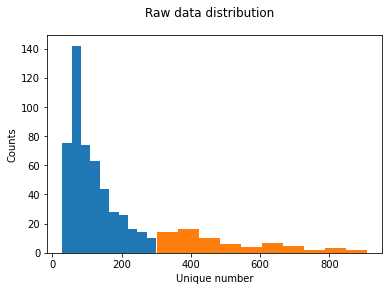

In [5]:
##-------------------所有数据的基本描述统计--------------------
##样本类别的统计和描述
otu_label["label"].describe()
values = otu_label["label"]
value_cnt = {}  # 将结果用一个字典存储
# 统计结果
for value in values:
    # get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
    value_cnt[value] = value_cnt.get(value, 0) + 1
# 打印输出结果
# print(value_cnt)

##特征筛选和描述统计
otu_label=pd.concat([label, otu_filter], axis=1)

cols = [c for c in otu_label.columns]   #返回数据的列名到列表里
print('Number of features: {}'.format(len(cols)))

##查看特征的数值范围
feature_numbers = [[],[],[]]
counts = [[], [], []]
for c in cols:
    typ = otu_label[c].dtype
    uniq = len(np.unique(otu_label[c]))         
    if uniq == 5 and typ == np.object:                                      
        counts[0].append(c)
        feature_numbers[0].append(uniq)
    elif uniq <= 300 and  typ == np.int32 :  
        counts[1].append(c)
        feature_numbers[1].append(uniq)
    else:
        counts[2].append(c)
        feature_numbers[2].append(uniq)
    
plt.hist(feature_numbers[1])
plt.hist(feature_numbers[2])
plt.xlabel("Unique number")
plt.ylabel("Counts")
plt.suptitle("Raw data distribution")

print('string variable: {}\n <=300 unique number: {} \n >300 unique number: {}\n'.format(*[len(c) for c in counts]))
# print('string variables:', counts[0])
# print('<=300 unique number:', counts[1])
# print('>300 unique number:', counts[2])

# 训练集和测试集划分

In [27]:
##---------训练集和测试集划分---------未考虑测序批次
#train
otu_label = pd.read_csv("otutab_norm.csv",header=0)
X=otu_label.drop(['label',"sample"], axis=1)# Features
y=otu_label['label']
# otu_label.to_csv("otutab_norm.csv",index=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2050,shuffle=True)

In [16]:
##---------训练集和测试集划分---------考虑测序批次
# X=otu_label.drop(['label'], axis=1)# Features
# y=otu_label['label']
# batch1=pd.read_table("batch1.txt",header=None)
# batch2=pd.read_table('batch2.2.txt',header=None)

# otu_label_batch1=otu_label[otu_label.index.isin(list(batch1[0]))] ##按照列名进行匹配
# otu_label_batch2=otu_label[otu_label.index.isin(list(batch2[0]))]
# X_test = otu_label_batch2.drop(['label'], axis=1)# Features
# y_test = otu_label_batch2['label']
# X_train = otu_label_batch1.drop(['label'], axis=1)# Features
# y_train = otu_label_batch1['label']
# X_test.head()
# X_test._stat_axis.values.tolist() ##row names
#X_train.to_csv('X_train.csv',index=1)
#X_test.to_csv('X_test.csv',index=1)

## 模型构建及参数调优 

模型一：随机森林

In [11]:
param = {
    'n_estimators':range(10,500,10),
    'max_features':range(1,20,1)
}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(random_state=2050),
                        param_grid = param,
                        cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2050),
             n_jobs=-1,
             param_grid={'max_features': range(1, 20),
                         'n_estimators': range(10, 500, 10)})

In [12]:
best_estimator = gsearch1.best_estimator_
#best_estimator = RandomForestClassifier(max_features=8, n_estimators=750, random_state=2050)
print(f'best params:{gsearch1.best_params_}')
print('best accuracy:%f' % gsearch1.best_score_)
print(best_estimator)

best params:{'max_features': 17, 'n_estimators': 370}
best accuracy:0.944921
RandomForestClassifier(max_features=17, n_estimators=370, random_state=2050)


In [13]:
#对训练集进行交叉验证
scores = cross_val_score(best_estimator, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.94 (+/- 0.02)


In [14]:
scores

array([0.93125   , 0.95      , 0.94375   , 0.9625    , 0.93710692])

In [15]:
#对测试集进行测试
best_estimator.fit(X_train,y_train)
#y_pred=best_estimator.predict_proba(X_test)
y_pred=best_estimator.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.905


In [16]:
y_train.value_counts()

CR    163
XR    162
FJ    161
JK    158
JZ    155
Name: label, dtype: int64

In [17]:
y_test.value_counts()

JZ    45
JK    41
FJ    39
XR    38
CR    37
Name: label, dtype: int64

In [18]:
y_test_pred=best_estimator.predict_proba(X_test)

In [23]:
# nn = pd.DataFrame(pd.concat([pd.DataFrame(y_test_pred,columns=['CR','FJ','JK','JZ','XR']),
#                              pd.DataFrame(y_test.values,columns=['True_label']),
#                             pd.DataFrame(y_test._stat_axis.values.tolist(),columns=['Sample']),
#                             pd.DataFrame(y_pred,columns=['Pred_label'])
#                             ],axis=1))
# nn.head()
# nn.to_csv('y_test_pred.csv',index=0)

In [19]:
alldata = pd.DataFrame(pd.concat([pd.DataFrame(y_test._stat_axis.values.tolist(),columns=['Sample']),
                             pd.DataFrame(y_test.values,columns=['True_label']),
                             pd.DataFrame(y_pred,columns=['Pred_label']),
                             pd.DataFrame(np.array(X_test),columns=X_test.columns)
                            ],axis=1))

In [25]:
# alldata.to_csv('alldata.csv',index=0)

In [26]:
# predict_probs = best_estimator.predict_proba(X)
# all_probs = pd.concat([pd.DataFrame(X.index),pd.DataFrame(predict_probs,columns=['JK','JZ','CR'])],axis=1)
# all_probs[:10].to_csv('all_probs_text.csv',index=0)

In [20]:
importance = best_estimator.feature_importances_
feature_imp = pd.Series(importance,index=X_train.columns).sort_values(ascending=False)
feature_imp

Otu527    0.013805
Otu325    0.011295
Otu511    0.010836
Otu202    0.009924
Otu87     0.009511
            ...   
Otu510    0.000534
Otu633    0.000514
Otu583    0.000483
Otu421    0.000481
Otu457    0.000432
Length: 561, dtype: float64

In [21]:
filter_feature = feature_imp[feature_imp.values>0.002] 
filter_feature.index
filter_feature.head()
# filter_feature = feature_imp
# filter_feature.to_csv('filter_feature.csv',index=1)
filter_feature.head()

Otu527    0.013805
Otu325    0.011295
Otu511    0.010836
Otu202    0.009924
Otu87     0.009511
dtype: float64

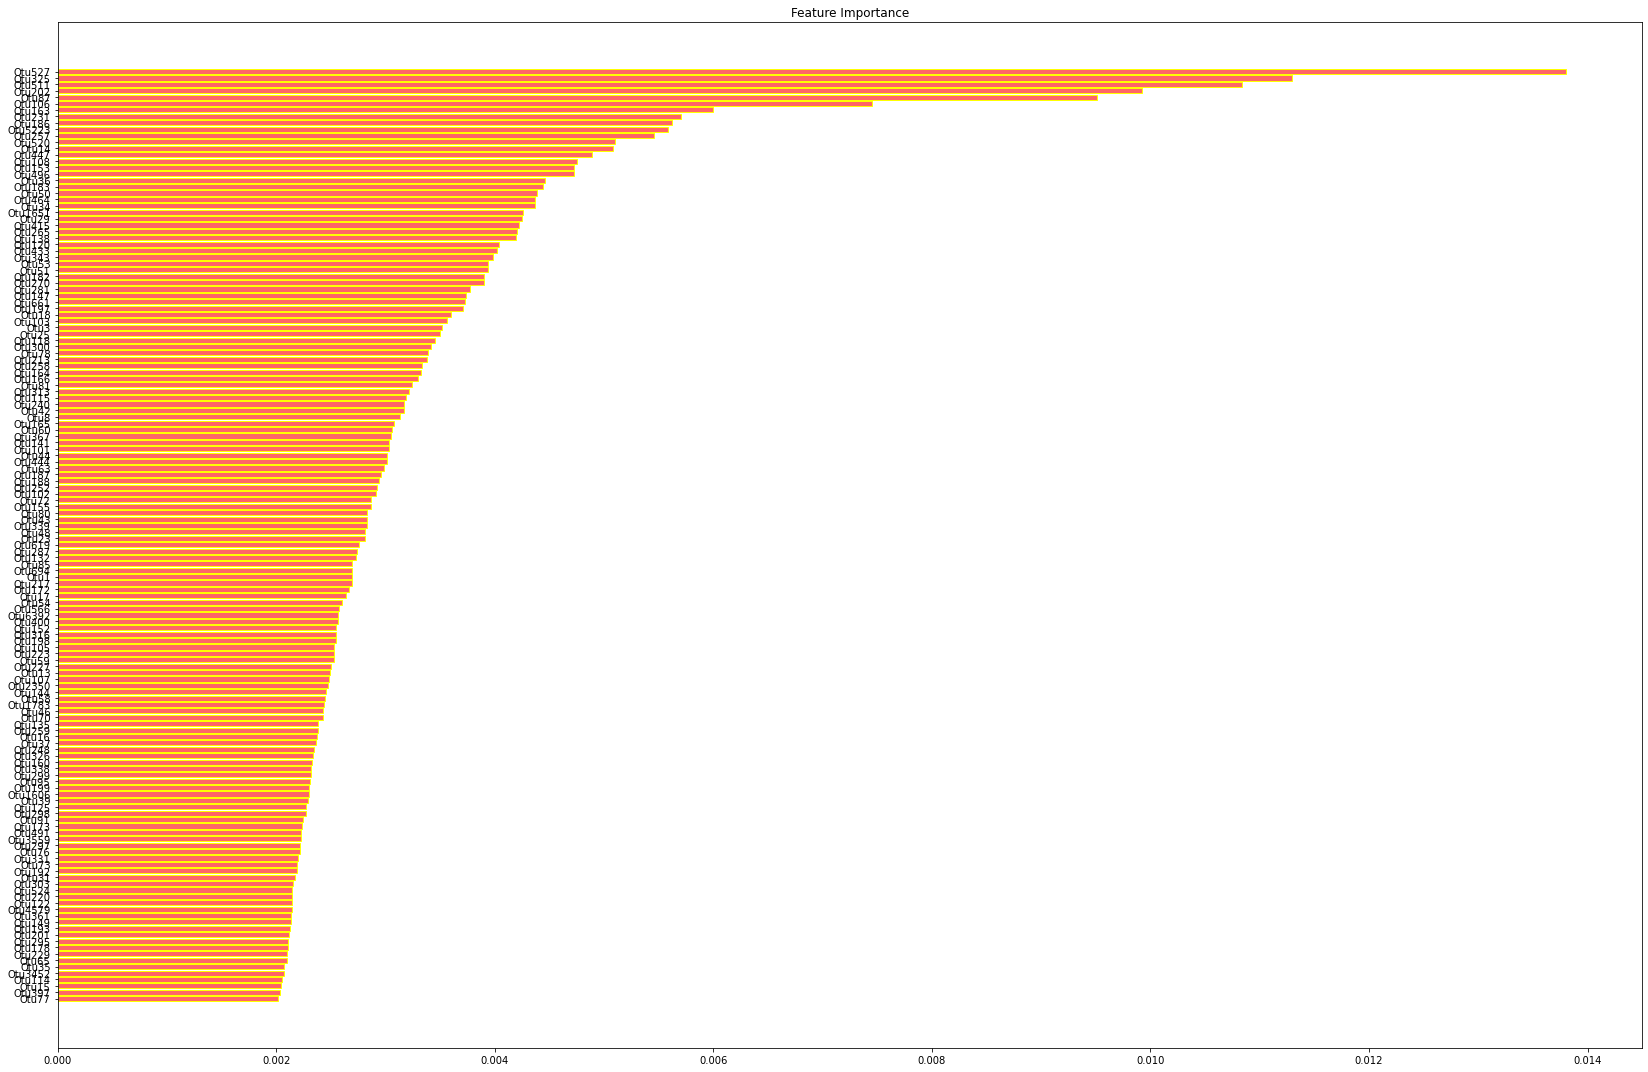

In [22]:
# plot feature importance
indices = np.argsort(filter_feature)
selectn = filter_feature.shape[0]
fig=plt.figure(figsize=(23,15))
ax=fig.add_subplot(111)

ax.barh(range(selectn),filter_feature[indices],facecolor='#FF6666', edgecolor='#FFFF00')
ax.set_yticks(range(selectn))
ax.set_yticklabels(indices[::-1].index)
#ax.set_xlim(0, np.max(indices,)*1.1)
ax.set_title('Feature Importance')
plt.tight_layout()
plt.show()

模型二: Softmax函数做多分类问题-Logistic函数的推广

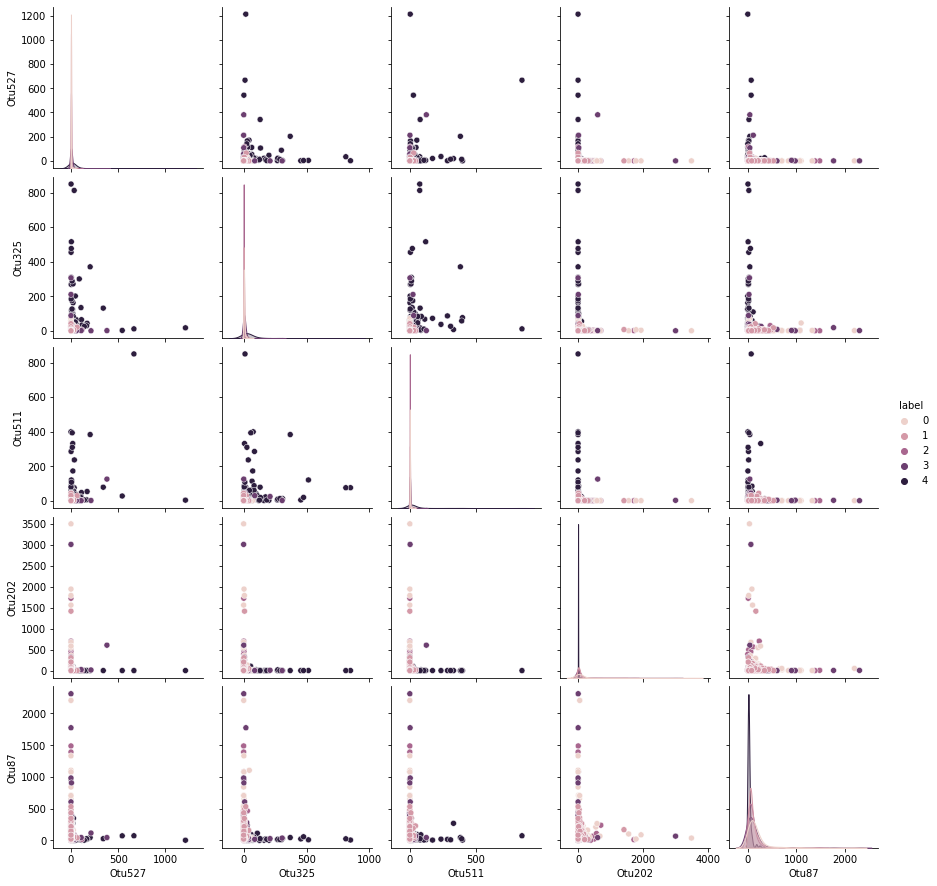

In [241]:
# 可视化数据
data = pd.DataFrame(otu_label[["label","Otu527","Otu325","Otu511","Otu202","Otu87"]])
sns.pairplot(data,hue="label")

In [255]:
# sklearn包做逻辑回归-----二分类问题
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
# 训练逻辑回归模型
log_model.fit(xtrain_data, ytrain_index)
# 预测y的值
y_pred = log_model.predict(xtest_data)
# y_pred = log_model.predict(xtrain_data)
# 查看测试结果
print(metrics.confusion_matrix(ytest_index, y_pred))
print(metrics.classification_report(ytest_index, y_pred))

# print(metrics.confusion_matrix(ytrain_index, y_pred))
# print(metrics.classification_report(ytrain_index, y_pred))

[[40  1]
 [13 24]]
              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85        41
         1.0       0.96      0.65      0.77        37

    accuracy                           0.82        78
   macro avg       0.86      0.81      0.81        78
weighted avg       0.85      0.82      0.81        78



E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [248]:
# sklearn包做逻辑回归-----五分类问题
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

std = StandardScaler()
x_train = std.fit_transform(xtrain_data)
x_test = std.fit_transform(xtest_data)
#训练模型
model = LogisticRegression(penalty='l2',C=1,)
model.fit(x_train,Y_train)
y_pred = model.predict(x_test)
# y_pred = model.predict(x_train)

# print(metrics.confusion_matrix(Y_train, y_pred))
# print(metrics.classification_report(Y_train, y_pred))

print(metrics.confusion_matrix(Y_test,y_pred))
print(metrics.classification_report(Y_test, y_pred))

[[10  6 20  3  2]
 [ 5  2 26  3  2]
 [ 2  0 36  1  0]
 [ 6  0 28  5  6]
 [ 0  0  0  1 36]]
              precision    recall  f1-score   support

           0       0.43      0.24      0.31        41
           1       0.25      0.05      0.09        38
           2       0.33      0.92      0.48        39
           3       0.38      0.11      0.17        45
           4       0.78      0.97      0.87        37

    accuracy                           0.45       200
   macro avg       0.44      0.46      0.38       200
weighted avg       0.43      0.45      0.37       200



In [208]:
# 肠癌样本和健康样本的二分类问题-五个贡献度大的特征-------源码编写(-----梯度更新为nan-----)
# 数据输入和准备
x_train = np.array(X_train[(y_train == 0) | (y_train == 4)][["Otu527","Otu325","Otu511","Otu202","Otu87"]])
Y_train = np.array(y_train[(y_train == 0) | (y_train == 4)])
x_test = np.array(X_test[(y_test == 0) | (y_test == 4)][["Otu527","Otu325","Otu511","Otu202","Otu87"]])
Y_test = np.array(y_test[(y_test == 0) | (y_test == 4)])
# Y_train[Y_train=="CR"]=1
# Y_train[Y_train=="JK"]=0
# Y_test[Y_test=="CR"]=1
# Y_test[Y_test=="JK"]=0

num_train = len(x_train)
num_test = len(x_test)

# 中心化处理
x_train = x_train - np.mean(x_train,axis=0)
x_test = x_test - np.mean(x_test,axis=0)

x0_train = np.ones(num_train).reshape(-1,1)
x0_test = np.ones(num_test).reshape(-1,1)

xtrain_data = tf.cast(tf.concat((x0_train,x_train),axis=1),tf.float32)
ytrain_index = tf.cast(Y_train.reshape(-1,1),tf.float32)
xtest_data = tf.cast(tf.concat((x0_test,x_test),axis=1),tf.float32)
ytest_index = tf.cast(Y_test.reshape(-1,1),tf.float32)

xtrain_data.shape,ytrain_index.shape,xtest_data.shape,ytest_index.shape

(TensorShape([321, 6]),
 TensorShape([321, 1]),
 TensorShape([78, 6]),
 TensorShape([78, 1]))

In [213]:
# 设置超参数
learn_rate = 0.01
iter = 100
display_step = 10

# 设置初始值
np.random.seed(520)
W = tf.Variable(np.random.randn(a.shape[1],1),dtype=tf.float32)
W

In [243]:
# 训练模型
loss_train = []
loss_test = []
acc_train = []
acc_test = []

for i in range(0,iter+1):
    
    with tf.GradientTape() as tape:
        PRED_train = 1/(1+tf.exp(-tf.matmul(xtrain_data,W)))
        train_Loss = -tf.reduce_mean(ytrain_index*tf.math.log(PRED_train+0.0000001)+(1-ytrain_index)*tf.math.log(1-PRED_train+0.000001))
        PRED_test = 1/(1+tf.exp(-tf.matmul(xtest_data,W)))
        test_Loss = -tf.reduce_mean(ytest_index*tf.math.log(PRED_test+0.0000001)+(1-ytest_index)*tf.math.log(1-PRED_test+0.0000001))
        
    train_acc = tf.reduce_mean(tf.cast(tf.equal(tf.where(PRED_train.numpy()<0.5,0.,1.),ytrain_index),tf.float32))
    test_acc = tf.reduce_mean(tf.cast(tf.equal(tf.where(PRED_test.numpy()<0.5,0.,1.),ytest_index),tf.float32))
    
    loss_train.append(train_Loss)
    loss_test.append(test_Loss)
    
    acc_train.append(train_acc)
    acc_test.append(test_acc)
    dl_dw = tape.gradient(train_Loss,W)
    W.assign_sub(learn_rate*dl_dw)
#     print(train_Loss)
#     print(f"i:{i},dl_dw:{dl_dw}")
#     print(W)
    
#     if i % display_step == 0:
#         print("trainLoss: %f, testLoss: %f"%(train_Loss,test_Loss))
#         print("trainACC: %f, testACC: %f"%(train_acc,test_acc))

<ipython-input-243-799297607862>:15: RuntimeWarning: invalid value encountered in less
  train_acc = tf.reduce_mean(tf.cast(tf.equal(tf.where(PRED_train.numpy()<0.5,0.,1.),ytrain_index),tf.float32))
<ipython-input-243-799297607862>:16: RuntimeWarning: invalid value encountered in less
  test_acc = tf.reduce_mean(tf.cast(tf.equal(tf.where(PRED_test.numpy()<0.5,0.,1.),ytest_index),tf.float32))


In [217]:
# Softmax做多分类-----五分类模型(-----梯度更新为nan-----)
x_train = np.array(X_train[["Otu527","Otu325","Otu511","Otu202","Otu87"]])
Y_train = np.array(y_train)
x_test = np.array(X_test[["Otu527","Otu325","Otu511","Otu202","Otu87"]])
Y_test = np.array(y_test)

num_train = len(x_train)
num_test = len(x_test)

x0_train = np.ones(num_train).reshape(-1,1)
x0_test = np.ones(num_test).reshape(-1,1)

xtrain_data = tf.cast(tf.concat((x0_train,x_train),axis=1),tf.float32)
ytrain_index = tf.one_hot(tf.constant(Y_train,dtype=tf.int32),5)

xtest_data = tf.cast(tf.concat((x0_test,x_test),axis=1),tf.float32)
ytest_index = tf.one_hot(tf.constant(Y_test,dtype=tf.int32),5)

xtrain_data.shape,ytrain_index.shape,xtest_data.shape,ytest_index.shape

(TensorShape([799, 6]),
 TensorShape([799, 5]),
 TensorShape([200, 6]),
 TensorShape([200, 5]))

In [221]:
# 设置模型超参数，设置模型初始参数
learn_rate = 0.2
iter = 500
display_step = 100

np.random.seed(612)
W = tf.Variable(np.random.randn(xtrain_data.shape[1],5),dtype=tf.float32)

In [227]:
# 训练模型
acc_train = []
cce_train = []

acc_test = []
cce_test = []
for i in range(0,iter+1):
    with tf.GradientTape() as tape:
        PRED_train = tf.nn.softmax(tf.matmul(xtrain_data,W))
        Loss_train = -tf.reduce_sum(ytrain_index*tf.math.log(PRED_train+0.0001))/num_train
        
        PRED_test = tf.nn.softmax(tf.matmul(xtest_data,W))
        Loss_test = -tf.reduce_sum(ytest_index*tf.math.log(PRED_test+0.0001))/num_train 

    accuracy_train = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(PRED_train.numpy(),axis=1),Y_train),tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(PRED_test.numpy(),axis=1),Y_test),tf.float32))

    acc_train.append(accuracy_train)
    cce_train.append(Loss_train)
    
    acc_test.append(accuracy_test)
    cce_test.append(Loss_test)
#     dl_dw = tape.gradient(Loss_train,W)
    W.assign_sub(learn_rate*dl_dw)
    
    if i % display_step == 0:
        print("i: %i,Acc: %f,Loss:%f"%(i,accuracy_train,Loss_train))

i: 0,Acc: 0.197747,Loss:nan
i: 100,Acc: 0.197747,Loss:nan
i: 200,Acc: 0.197747,Loss:nan
i: 300,Acc: 0.197747,Loss:nan
i: 400,Acc: 0.197747,Loss:nan
i: 500,Acc: 0.197747,Loss:nan


模型三: 多种弱分类器的集成学习

In [32]:
from sklearn.model_selection import cross_val_score   # 10折交叉验证评价模型
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline   # 管道简化工作流
from sklearn.preprocessing import StandardScaler  # 标准化数据
from sklearn.preprocessing import LabelEncoder   # 标签化分类变量

clf1 = LogisticRegression(penalty='l2',C=0.001)
clf2 = DecisionTreeClassifier()
clf3 = KNeighborsClassifier()

std = StandardScaler()
x_train = std.fit_transform(X_train)
x_test = std.fit_transform(X_test)

pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic regression','Decision tree','KNN']
print('10-folds cross validation :\n')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(clf, x_train, y_train, cv=10)
    print(scores)
    print("ACCURACY: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),label))

10-folds cross validation :

[0.75      0.8125    0.7125    0.6875    0.7375    0.7875    0.725
 0.775     0.725     0.7721519]
ACCURACY: 0.75(+/- 0.04)[Logistic regression]
[0.575      0.5875     0.475      0.6375     0.625      0.6
 0.6        0.625      0.55       0.64556962]
ACCURACY: 0.59(+/- 0.05)[Decision tree]
[0.5625     0.55       0.4375     0.525      0.525      0.6125
 0.5375     0.5875     0.475      0.55696203]
ACCURACY: 0.54(+/- 0.05)[KNN]


In [20]:
# K近邻分类
knn = KNeighborsClassifier()    #实例化KNN模型
knn.fit(X_train, y_train)      #放入训练数据进行训练
# print(knn.predict(X_test))           #打印预测内容
Counter(knn.predict(X_test)==y_test)

Counter({True: 92, False: 108})

In [24]:
# 决策树分类
from sklearn import tree
dtc = tree.DecisionTreeClassifier(criterion="entropy")
clf = dtc.fit(X_train, y_train)
# print(clf.predict(X_test))
Counter(clf.predict(X_test)==y_test)

Counter({True: 125, False: 75})

In [28]:
# 逻辑回归分类
std = StandardScaler()
x_train = std.fit_transform(X_train)
x_test = std.fit_transform(X_test)
#训练模型
model = LogisticRegression(penalty='l2',C=1,)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
Counter(y_pred==y_test)

Counter({True: 161, False: 39})

In [33]:
## 绘制决策树模型------环境变量配置未完成
# from sklearn.datasets import load_iris
# from sklearn import tree
# from sklearn.model_selection import train_test_split
# import graphviz
# import os

# def multi_class_tree():
#     iris = load_iris()
#     x = iris['data']
#     y = iris['target']
#     dtc = tree.DecisionTreeClassifier(criterion="entropy")
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
#     clf = dtc.fit(x_train, y_train)
#     print(clf.predict(x_test))
#     print(y_test)
#     dot_data = tree.export_graphviz(clf, out_file=None)
#     graph = graphviz.Source(dot_data)
#     os.environ["PATH"] += os.pathsep + 'F:/Program Files/Graphviz2.38/bin/'
#     graph.render("iris", view=True)

# multi_class_tree()

In [35]:
## 我们使用MajorityVoteClassifier集成：
from sklearn.ensemble import VotingClassifier
mv_clf = VotingClassifier(estimators=[('pipe1',pipe1),('clf2',clf2),('pipe3',pipe3)],voting='soft')
clf_labels += ['MajorityVoteClassifier']
all_clf = [pipe1,clf2,pipe3,mv_clf]
print('10-folds cross validation :\n')
for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,X=x_train,y=y_train,cv=10)
    print("ACCURACY: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),label))
## 对比下面结果，可以得知多数投票方式的分类算法，抗差能力更强。

10-folds cross validation :

ACCURACY: 0.75(+/- 0.04)[Logistic regression]
ACCURACY: 0.60(+/- 0.05)[Decision tree]
ACCURACY: 0.54(+/- 0.05)[KNN]
ACCURACY: 0.65(+/- 0.05)[MajorityVoteClassifier]


In [41]:
# 基于bagging思想的套袋集成技术
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=None)   #选择决策树为基本分类器
bag = BaggingClassifier(base_estimator=tree,n_estimators=500,max_samples=1.0,max_features=1.0,bootstrap=True,
                        bootstrap_features=False,n_jobs=1,random_state=1)
from sklearn.metrics import accuracy_score
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train,bag_test))

Bagging train/test accuracies 1.000/0.890


In [45]:
# 基于boosting思想的自适应增强方法----Adaboost集成建模
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.625


In [53]:
## 1. 简单堆叠3折CV分类
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 42

clf1 = KNeighborsClassifier()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.38 (+/- 0.01) [KNN]
Accuracy: 0.90 (+/- 0.01) [Random Forest]
Accuracy: 0.57 (+/- 0.02) [Naive Bayes]
Accuracy: 0.86 (+/- 0.02) [StackingClassifier]


In [54]:
#  conda install mlxtend --channel conda-forge  安装mlxtend库

In [55]:
## 2.使用概率作为元特征
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,
                            meta_classifier=lr,
                            random_state=42)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf],
                      ['KNN',
                       'Random Forest',
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train,
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.38 (+/- 0.01) [KNN]
Accuracy: 0.90 (+/- 0.01) [Random Forest]
Accuracy: 0.57 (+/- 0.02) [Naive Bayes]
Accuracy: 0.84 (+/- 0.03) [StackingClassifier]


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=42)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf,
                    param_grid=params,
                    cv=5,
                    refit=True)
grid.fit(X_train, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  )
E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  )


0.596 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.812 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.640 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.840 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.564 +/- 0.03 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.822 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.626 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.847 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

In [57]:
## 4.在不同特征子集上运行的分类器的堆叠
###不同的1级分类器可以适合训练数据集中的不同特征子集。以下示例说明了如何使用scikit-learn管道和ColumnSelector：
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),  # 选择第0,2列
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),  # 选择第1,2,3列
                      LogisticRegression())

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2],
                            meta_classifier=LogisticRegression(),
                            random_state=42)

sclf.fit(X_train, y_train)

E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  )
E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  )
E:\anaconda3\envs\tensorfl

StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 2))),
                                                  ('logisticregression',
                                                   LogisticRegression())]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(1, 2,
                                                                        3))),
                                                  ('logisticregression',
                                                   LogisticRegression())])],
                     meta_classifier=LogisticRegression(), random_state=42)

E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

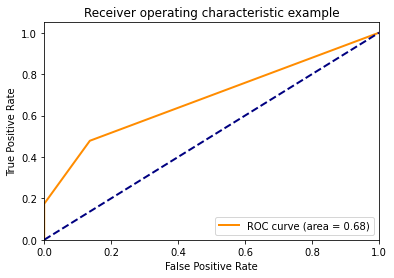

In [21]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2,3,4])
n_classes = y.shape[1]

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

clf1 =  LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr)


# classifier = OneVsRestClassifier(sclf)
# scores =classifier.fit(X_train, y_train)
# print("Accuracy: %0.2f (+/- %0.2f) "% (scores.mean(), scores.std()))

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

第四种模型：支持向量机

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import sklearn.svm as svm
model = svm.SVC(kernel="linear", decision_function_shape="ovo")

In [28]:
def svc(kernel):
    return svm.SVC(kernel=kernel, decision_function_shape="ovo")


def nusvc():
    return svm.NuSVC(decision_function_shape="ovo")


def linearsvc():
    return svm.LinearSVC(multi_class="ovr")


def modelist():
    modelist = []
    kernalist = {"linear", "poly", "rbf", "sigmoid"}
    for each in kernalist:
        modelist.append(svc(each))
    modelist.append(nusvc())
    modelist.append(linearsvc())
    return modelist


def svc_model(model):
    model.fit(X_train, y_train)
    acu_train = model.score(X_train, y_train)
    acu_test = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average="macro")
    return acu_train, acu_test, recall


def run_svc_model(modelist):
    result = {"kernel": [],
              "acu_train": [],
              "acu_test": [],
              "recall": []
              }

    for model in modelist:
        acu_train, acu_test, recall = svc_model(model)
        try:
            result["kernel"].append(model.kernel)
        except:
            result["kernel"].append(None)
        result["acu_train"].append(acu_train)
        result["acu_test"].append(acu_test)
        result["recall"].append(recall)

    return pd.DataFrame(result)

run_svc_model(modelist())


E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,kernel,acu_train,acu_test,recall
0,sigmoid,0.514393,0.480,0.482943
1,linear,1.000000,0.615,0.623071
2,rbf,0.772215,0.495,0.498928
3,poly,0.758448,0.415,0.425057
4,rbf,0.922403,0.590,0.594562
5,None,0.994994,0.670,0.673904


In [29]:
def test_c():
    result = {"C": [],
              "acu_train": [],
              "acu_test": [],
              "recall": []
              }
    for c in range(10, 101, 10):
        model = svm.SVC(kernel="linear", C=c, decision_function_shape="ovo")
        acu_train, acu_test, recall = svc_model(model)
        result["C"].append(c)
        result["acu_train"].append(acu_train)
        result["acu_test"].append(acu_test)
        result["recall"].append(recall)
    df = pd.DataFrame(result)
    return df
test_c()

,C,acu_train,acu_test,recall
0,10,1.0,0.615,0.623071
1,20,1.0,0.615,0.623071
2,30,1.0,0.615,0.623071
3,40,1.0,0.615,0.623071
4,50,1.0,0.615,0.623071
5,60,1.0,0.615,0.623071
6,70,1.0,0.615,0.623071
7,80,1.0,0.615,0.623071
8,90,1.0,0.615,0.623071
9,100,1.0,0.615,0.623071


In [30]:
def test_degree():
    result = {"degree": [],
              "acu_train": [],
              "acu_test": [],
              "recall": []
              }
    for d in range(1, 11, 1):
        model = svm.SVC(kernel="poly", degree=d, decision_function_shape="ovo")
        acu_train, acu_test, recall = svc_model(model)
        result["degree"].append(d)
        result["acu_train"].append(acu_train)
        result["acu_test"].append(acu_test)
        result["recall"].append(recall)
    df = pd.DataFrame(result)
    return df
    
test_degree()

,degree,acu_train,acu_test,recall
0,1,0.662078,0.520,0.522790
1,2,0.769712,0.500,0.502850
2,3,0.758448,0.415,0.425057
3,4,0.703379,0.405,0.415775
4,5,0.610763,0.325,0.332344
5,6,0.568210,0.270,0.277735
6,7,0.550688,0.240,0.247887
7,8,0.540676,0.225,0.232198
8,9,0.531915,0.220,0.229072
9,10,0.530663,0.225,0.232833


In [40]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

#朴素贝叶斯做多分类
gaussian = GaussianNB()
multi = MultinomialNB()
bernoul = BernoulliNB()
models = [gaussian,multi, bernoul]

def svc_model(model):
    model.fit(X_train, y_train)
    acu_train = model.score(X_train, y_train)
    acu_test = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average="macro")
    return acu_train, acu_test, recall

result = {
          "acu_train": [],
          "acu_test": [],
          "recall": []
          }
for each in models:
    acu_train, acu_test, recall = svc_model(each)
    result["acu_train"].append(acu_train)
    result["acu_test"].append(acu_test)
    result["recall"].append(recall)
result = pd.DataFrame(result)
new_col = ['Gaussian', 'Multinomial', 'Bernoulli']
result.index = new_col
result

,acu_train,acu_test,recall
Gaussian,0.881101,0.525,0.534406
Multinomial,0.742178,0.540,0.548558
Bernoulli,0.857322,0.770,0.775513


In [46]:
## Xgboost训练模型
import xgboost as xgb
from xgboost import plot_importance

#模型参数
param_dict = {'n_estimators':range(50,500,10),
              'max_depth':range(2,15,1),
              'learning_rate':np.linspace(0.01,2,20),
              'subsample':np.linspace(0.6,0.9,20),
              'colsample_bytree':np.linspace(0.5,0.98,10),
              'min_child_weight':range(1,9,1),
              'gamma':[i/10.0 for i in range(0,5)],
              'colsample_bytree':np.linspace(0.6,0.9,20),
              'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
             }
gsearch2 = RandomizedSearchCV(xgb.XGBClassifier(random_state=2050),
                              param_dict,
                              n_iter=20,
                              cv=5,
                              n_jobs=-1)

ModuleNotFoundError: No module named 'xgboost'

In [49]:
pip install xgboost --index https://pypi.mirrors.ustc.edu.cn/simple/

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement xgboost
ERROR: No matching distribution found for xgboost


In [ ]:
#在训练集上训练
gsearch2.fit(X_train,y_train,)
print(f'best params:{gsearch2.best_params_}')
# 返回准确率
print('best accuracy:%f' % gsearch2.best_score_)
# 返回最佳训练器
best_estimator = gsearch2.best_estimator_
print(best_estimator)

In [ ]:
#对训练集进行交叉验证
scores = cross_val_score(best_estimator, X_train, y_train, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#对测试集测试
best_estimator.fit(X_train,y_train)
y_pred=best_estimator.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# 模型评估

In [23]:
#混淆矩阵
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          CR       0.86      1.00      0.92        37
          FJ       0.86      0.79      0.83        39
          JK       0.98      1.00      0.99        41
          JZ       0.85      0.87      0.86        45
          XR       1.00      0.87      0.93        38

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.90       200



In [24]:
array_confusion = metrics.confusion_matrix(y_test, y_pred)
cm = array_confusion
array_confusion = array_confusion.T
array_confusion

array([[37,  1,  0,  4,  1],
       [ 0, 31,  0,  2,  3],
       [ 0,  1, 41,  0,  0],
       [ 0,  6,  0, 39,  1],
       [ 0,  0,  0,  0, 33]], dtype=int64)

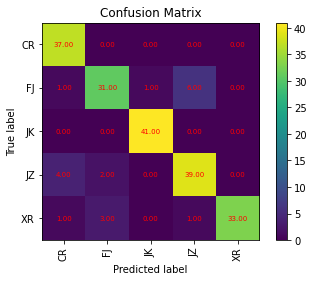

In [26]:
#绘制混淆矩阵图
# disp = metrics.plot_confusion_matrix(gsearch1, X_test, y_test)
# disp.figure_.suptitle("Confusion Matrix")
# print("Confusion matrix:\n%s" % disp.confusion_matrix)

def plot_confusion_matrix(cm,labels,title='Confusion Matrix'):
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')

labels = ['CR','FJ','JK','JZ','XR'] #五分类
# labels = ['JK','JZ','CR'] #三分类
plot_confusion_matrix(cm,labels)

<ipython-input-48-ef0316edeaaf>:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


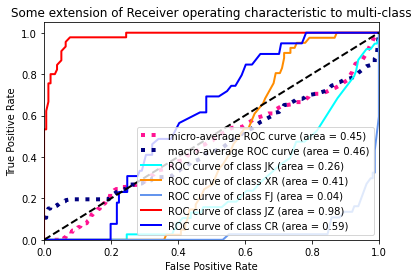

In [48]:
classe = ["JK","XR","FJ","JZ","CR"]
y_test = label_binarize(y_test, classes=["JK","XR","FJ","JZ","CR"])

# 设置种类
n_classes = y_test.shape[1]
y_score = y_test_pred

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"red",'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classe[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [27]:
TP_0 = array_confusion[0,0]
FP_0 = sum(array_confusion[0,1:5])
FN_0 = sum(array_confusion[1:5,0])
TN_0 = sum(array_confusion[1,1:5]+array_confusion[2,1:5]+array_confusion[3,1:5]+array_confusion[4,1:5])-FN_0
# 输出肠癌的灵敏度和特异性
print('肠癌的灵敏度为：%.2f'%(TP_0/(TP_0+FN_0)))
print('肠癌的特异性为：%.2f'%(TN_0/(FP_0+TN_0)))

肠癌的灵敏度为：1.00
肠癌的特异性为：0.96


In [28]:
TP_1 = array_confusion[1,1]
FP_1 = array_confusion[1,0]+sum(array_confusion[1,2:5])
FN_1 = array_confusion[0,1]+sum(array_confusion[2:5,1])
TN_1 = sum(array_confusion[0,:5])+sum(array_confusion[2,:5])+sum(array_confusion[3,:5])+sum(array_confusion[4,:5])-FN_1
# 输出非进展的灵敏度和特异性
print('非进展的灵敏度为：%.2f'%(TP_1/(TP_1+FN_1)))
print('非进展的特异性为：%.2f'%(TN_1/(TN_1+FP_1)))

非进展的灵敏度为：0.79
非进展的特异性为：0.97


In [29]:
TP_1 = array_confusion[2,2]
FP_1 = sum(array_confusion[2,0:2])+sum(array_confusion[2,3:5])
FN_1 = sum(array_confusion[0:2,2])+sum(array_confusion[3:5,2])
TN_1 = sum(array_confusion[0,])+sum(array_confusion[1,])+sum(array_confusion[3,])+sum(array_confusion[4,])-FN_1
# 输出健康的灵敏度和特异性
print('健康的灵敏度为：%.2f'%(TP_1/(TP_1+FN_1)))
print('健康的特异性为：%.2f'%(TN_1/(TN_1+FP_1)))

健康的灵敏度为：1.00
健康的特异性为：0.99


In [30]:
TP_1 = array_confusion[3,3]
FP_1 = sum(array_confusion[3,0:3])+sum(array_confusion[3,4:5])
FN_1 = sum(array_confusion[0:3,3])+sum(array_confusion[4:5,3])
TN_1 = sum(array_confusion[0,])+sum(array_confusion[1,])+sum(array_confusion[2,])+sum(array_confusion[4,])-FN_1
# 输出进展的灵敏度和特异性
print('进展的灵敏度为：%.2f'%(TP_1/(TP_1+FN_1)))
print('进展的特异性为：%.2f'%(TN_1/(TN_1+FP_1)))

进展的灵敏度为：0.87
进展的特异性为：0.95


In [31]:
TP_1 = array_confusion[4,4]
FP_1 = sum(array_confusion[4,0:4])
FN_1 = sum(array_confusion[0:4,4])
TN_1 = sum(array_confusion[0,])+sum(array_confusion[1,])+sum(array_confusion[2,])+sum(array_confusion[3,])-FN_1
# 输出息肉的灵敏度和特异性
print('息肉的灵敏度为：%.2f'%(TP_1/(TP_1+FN_1)))
print('息肉的特异性为：%.2f'%(TN_1/(TN_1+FP_1)))

息肉的灵敏度为：0.87
息肉的特异性为：1.00
